In [1]:
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode

/opt/conda/envs/pytorch-audio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = Path("/home/lyy92/data/Pascal-part")

In [4]:
label_names = {}
for line in classes_path.open("r").readlines():
    label, name = line.strip().split(":")
    label_names[label] = name
num_labels = len(label_names)
label_names

{'0': ' bg',
 '1': ' low_hand',
 '2': ' torso',
 '3': ' low_leg',
 '4': ' head',
 '5': ' up_leg',
 '6': ' up_hand'}

In [10]:
X, Y = next(iter(train_dataloader))
X.dtype, Y.dtype

(torch.float32, torch.int64)

In [12]:
model_unet = UNet(num_classes=TrainParams.num_classes).to(TrainParams.device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_unet.parameters(),
    lr=TrainParams.learning_rate)

In [14]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(TrainParams.epochs)):
    epoch_loss = 0
    for X, Y in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        X, Y = X.to(TrainParams.device), Y.to(TrainParams.device)
        optimizer.zero_grad()
        Y_pred = model_unet(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(train_dataloader))

100%|██████████| 30/30 [1:47:42<00:00, 215.41s/it]


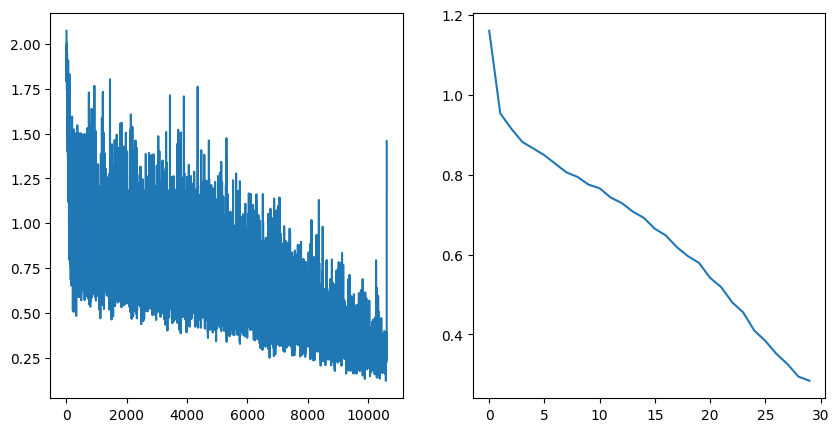

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [21]:
model_name = "U-Net-1.pth"
torch.save(model_unet.state_dict(), model_name)

In [17]:
model_path = model_name
model_ = UNet(num_classes=TrainParams.num_classes).to("cpu")
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [18]:
def infer(image: torch.Tensor, transform=None) -> torch.Tensor:
   if transform:
      image = transform(image)
   
   
   return torch.argmax(preds, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256) (256, 256) (256, 256, 3)
int64 int64 float32


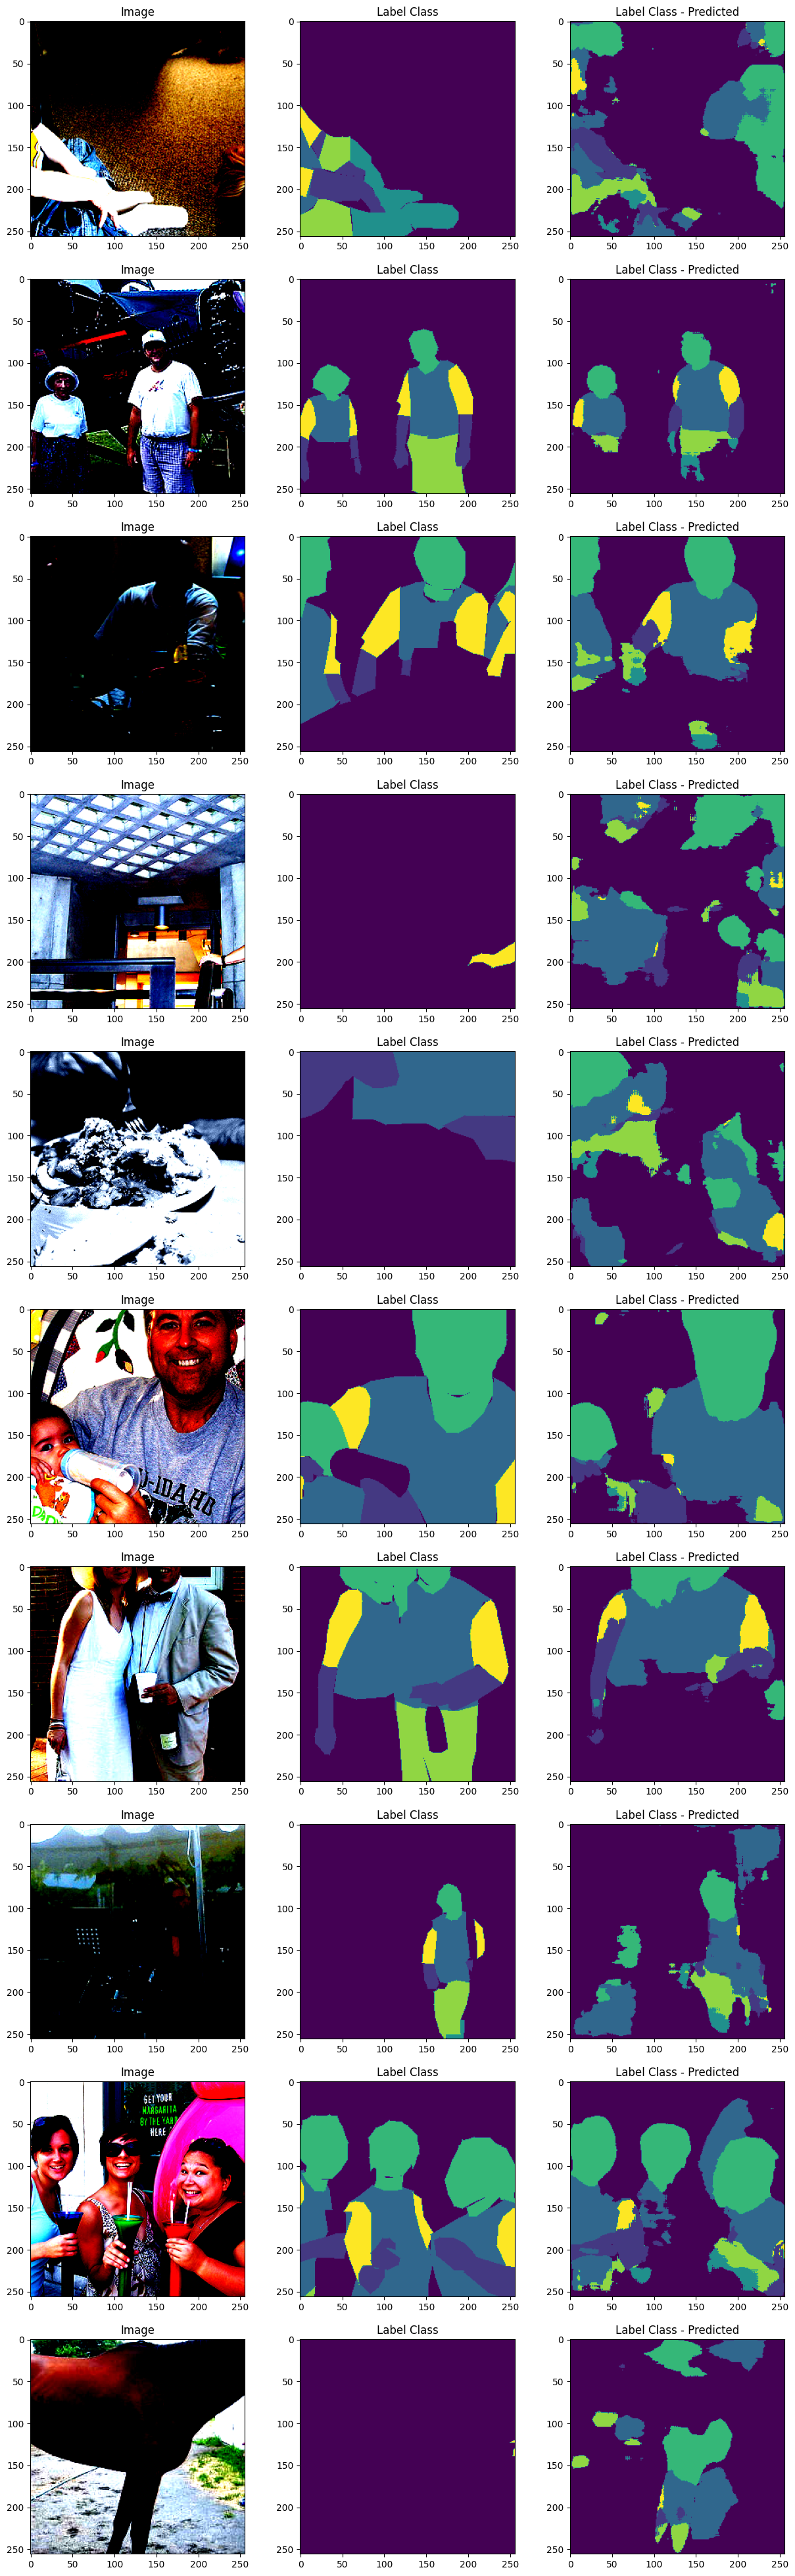

In [20]:
num_vals = 10
fig, axes = plt.subplots(num_vals, 3, figsize=(3*5, num_vals*5))

for i in range(num_vals):
    x_val, y_val = valid_data[np.random.randint(len(valid_data))]
    out = infer(image=x_val)
    
    image = x_val.permute(1, 2, 0).cpu().detach().numpy()
    label_class = y_val.cpu().detach().numpy()
    label_class_predicted = infer(image=x_val).squeeze().cpu().detach().numpy()
    print(label_class.shape, label_class_predicted.shape, image.shape)
    print(label_class.dtype, label_class_predicted.dtype, image.dtype)
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")